In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Simply not the quality I expected from Morris (love Brass Eye and Blue Jam). This is very much like a not so bad student film. What concerns me, in all this is WHY DID IT WIN A BAFTA??? Morris makes fun of 'enshrined mediocrity' (Ayn Rand) in much of his work (Nathan Barley) and yet with this piece is urinating down the backs of the talented and telling us its raining! <br /><br />I just hope as he has chosen a subject I would love to tackle (the humanity of terrorism - Four Lions) that he isn't going to cock that up, wasting the opportunity to make a statement about the farce of mainstream ignorance and opinion on this emotive and heavily spun phenomena."
 b'It is very hard to rate this film. As entertainment value for 21st century viewers, it fails miserably. However, for the student of early sound films and history, it is a jewel. "Show of Shows" was a revue filmed to compete with MGM\'s successful "Hollywood Revue of 1929", which still survives intact complete with its T

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[316,  22,   2, ...,   0,   0,   0],
       [  9,   7,  53, ...,   0,   0,   0],
       [ 49,   7,   1, ...,   0,   0,   0]])

In [8]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Simply not the quality I expected from Morris (love Brass Eye and Blue Jam). This is very much like a not so bad student film. What concerns me, in all this is WHY DID IT WIN A BAFTA??? Morris makes fun of 'enshrined mediocrity' (Ayn Rand) in much of his work (Nathan Barley) and yet with this piece is urinating down the backs of the talented and telling us its raining! <br /><br />I just hope as he has chosen a subject I would love to tackle (the humanity of terrorism - Four Lions) that he isn't going to cock that up, wasting the opportunity to make a statement about the farce of mainstream ignorance and opinion on this emotive and heavily spun phenomena."
Round-trip:  simply not the quality i expected from [UNK] love [UNK] eye and [UNK] [UNK] this is very much like a not so bad [UNK] film what [UNK] me in all this is why did it [UNK] a [UNK] [UNK] makes fun of [UNK] [UNK] [UNK] [UNK] in much of his work [UNK] [UNK] and yet with this piece is [UNK] down the [UNK] of the [U

Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[-0.0119229]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 694ms/step
[-0.0119229]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 804s 2s/step - loss: 0.6402 - accuracy: 0.5646 - val_loss: 0.4893 - val_accuracy: 0.7531
Epoch 2/10
391/391 [==============================] - 776s 2s/step - loss: 0.4450 - accuracy: 0.7872 - val_loss: 0.3869 - val_accuracy: 0.8208
Epoch 3/10
391/391 [==============================] - 788s 2s/step - loss: 0.3571 - accuracy: 0.8430 - val_loss: 0.3692 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 780s 2s/step - loss: 0.3306 - accuracy: 0.8590 - val_loss: 0.3578 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 784s 2s/step - loss: 0.3179 - accuracy: 0.8632 - val_loss: 0.3321 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 766s 2s/step - loss: 0.3101 - accuracy: 0.8696 - val_loss: 0.3315 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 772s 2s/step - loss: 0.3059 - accuracy: 0.8680 - val_loss: 0.3269 - val_accuracy: 0.8583

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 192s 491ms/step - loss: 0.3159 - accuracy: 0.8611
Test Loss: 0.3158654570579529
Test Accuracy: 0.8610799908638


(0.0, 0.6573221147060394)

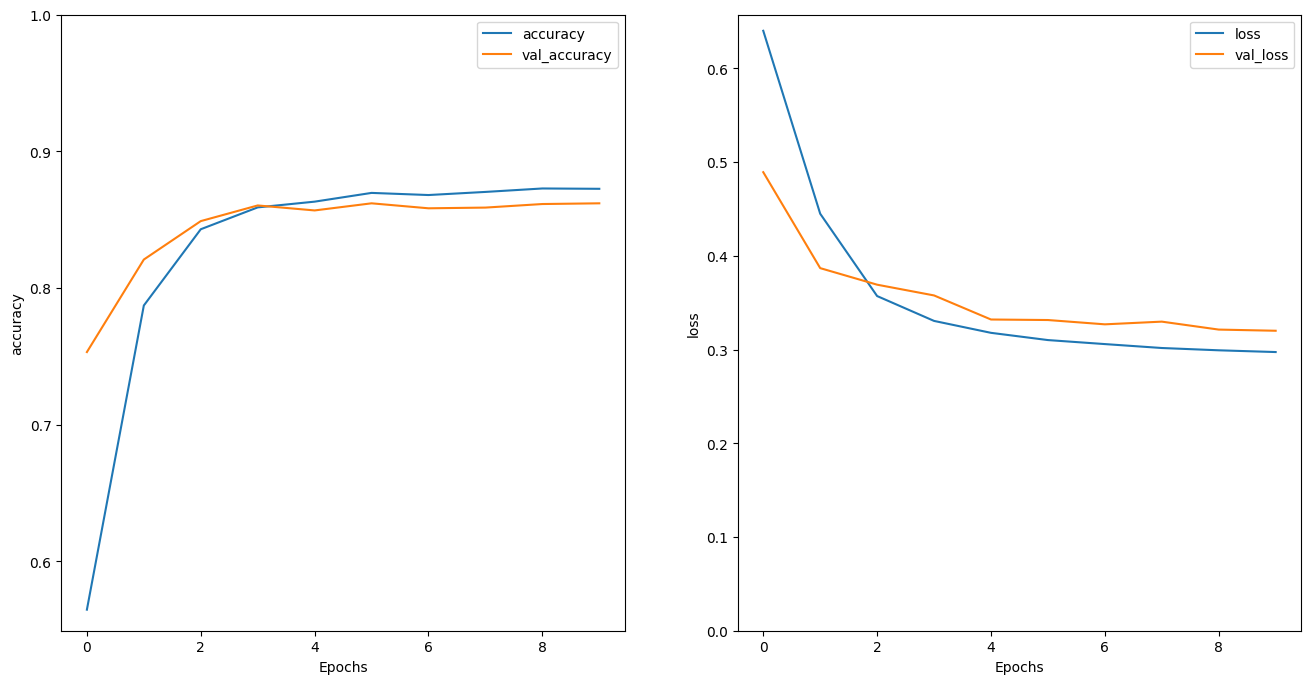

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)